<a href="https://colab.research.google.com/github/catalysthw/PINN/blob/main/euler_bernoulli_pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.autograd as autograd

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Analytical solution
def u_exact(x):
    return -(1/24)*x**4 + (1/6)*x**3 - 0.25*x**2

In [ ]:
# -------------------------------------------------------------
# Collocation points for enforcing the PDE in [0, 1]
# -------------------------------------------------------------
# Number of collocation points used to enforce the PDE in the interior of the domain [0, 1]
# These are the x-locations where we will evaluate the PDE residual v''(x) + 1 = 0.
n_c = 128

# Create a 1D tensor of collocation points uniformly spaced between 0 and 1.
# - device=device: put the tensor on CPU or GPU depending on the chosen device.
# - view(-1, 1): reshape to shape (n_c, 1) so it matches the network input dimension.
# - requires_grad_(True): we need gradients w.r.t. x_c to compute derivatives using autograd.
x_c = torch.linspace(0, 1, n_c, device=device).view(-1, 1).requires_grad_(True)


# -------------------------------------------------------------
# PINN network definition (fully-connected MLP with Tanh)
# -------------------------------------------------------------
class PINN(nn.Module):
    def __init__(self, layers=(1, 20, 20, 20, 1)):
        """
        layers: tuple defining the architecture.
        Example (1, 20, 20, 20, 1) means:
        input_dim=1 -> 20 -> 20 -> 20 -> output_dim=1 with Tanh between Linear layers.
        """
        super().__init__()
        net_layers = []
        for in_dim, out_dim in zip(layers[:-2], layers[1:-1]):
            net_layers.append(nn.Linear(in_dim, out_dim))
            net_layers.append(nn.Tanh())
        net_layers.append(nn.Linear(layers[-2], layers[-1]))
        self.network = nn.Sequential(*net_layers)

    def forward(self, x):
        return self.network(x)


# -------------------------------------------------------------
# Utility: n-th derivative via autograd
# -------------------------------------------------------------
def diff_n(u, x, n: int):
    """
    Compute the n-th derivative of u(x) w.r.t. x using autograd.
    u: tensor of shape (N, 1) that depends on x
    x: tensor with requires_grad=True
    n: derivative order
    """
    for _ in range(n):
        u = autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    return u


# -------------------------------------------------------------
# Analytical solution for comparison
# -------------------------------------------------------------
def analytic_solution(x_np):
    """
    Analytical solution for the beam problem:
    u''''(x) + 1 = 0 with boundary conditions:
    u(0)=0, u'(0)=0, u''(1)=0, u'''(1)=0.
    """
    return -x_np**4 / 24 + x_np**3 / 6 - x_np**2 / 4


# -------------------------------------------------------------
# Boundary points helper
# -------------------------------------------------------------
def make_boundary_points():
    """
    Create boundary points x = 0 and x = 1 with requires_grad=True,
    so that we can compute boundary derivatives via autograd.
    """
    x0 = torch.tensor([[0.0]], device=device, requires_grad=True)
    x1 = torch.tensor([[1.0]], device=device, requires_grad=True)
    return x0, x1


# =============================================================
# 1) Single network, 4th derivative strong form (u'''' + 1 = 0)
# =============================================================
def train_single_4th(num_epochs=5000, lr=1e-3):
    print("\n[1] Single network, 4th derivative strong form (u'''' + 1 = 0)")

    uv_net = PINN().to(device)
    opt = torch.optim.Adam(uv_net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1000, gamma=0.5)

    for epoch in range(num_epochs):
        opt.zero_grad()

        # PDE residual: u''''(x) + 1 = 0
        u = uv_net(x_c)
        u_xxxx = diff_n(u, x_c, 4)
        res_pde = u_xxxx + 1.0
        loss_pde = (res_pde**2).mean()

        # Boundary conditions:
        #   at x=0: u(0)=0, u'(0)=0
        #   at x=1: u''(1)=0, u'''(1)=0
        x0, x1 = make_boundary_points()

        u0 = uv_net(x0)
        u0_x = diff_n(uv_net(x0), x0, 1)
        u1_xx = diff_n(uv_net(x1), x1, 2)
        u1_xxx = diff_n(uv_net(x1), x1, 3)

        bc0 = u0**2 + u0_x**2
        bc1 = u1_xx**2 + u1_xxx**2
        loss_bc = bc0.mean() + bc1.mean()

        loss = loss_pde + loss_bc
        loss.backward()
        opt.step()
        scheduler.step()

        if epoch % 1000 == 0:
            print(f"[Single-4th] Epoch {epoch} | Loss: {loss.item():.4e}")

    # Evaluation
    x_eval = torch.linspace(0, 1, 200, device=device).view(-1, 1)
    u_pred = uv_net(x_eval).detach().cpu().numpy().flatten()
    x_np = x_eval.cpu().numpy().flatten()
    u_true = analytic_solution(x_np)
    return x_np, u_pred, u_true



In [ ]:
# =============================================================
# 2) Two networks: u_net and v_net where v ≈ u''
#    PDE: v''(x) + 1 = 0 + coupling v ≈ u''
# =============================================================
def train_two_net_shared_lr(num_epochs=5000, lr=1e-3):
    print("\n[2] Two networks (u, v=u''), shared learning rate")

    u_net = PINN().to(device)
    v_net = PINN().to(device)

    opt = torch.optim.Adam(
        list(u_net.parameters()) + list(v_net.parameters()),
        lr=lr
    )
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1000, gamma=0.5)

    for epoch in range(num_epochs):
        opt.zero_grad()

        # PDE for v: v''(x) + 1 = 0
        v = v_net(x_c)
        v_xx = diff_n(v, x_c, 2)
        res = v_xx + 1.0
        loss_pde = (res**2).mean()

        # Boundary conditions:
        #   at x=0: u(0)=0, u'(0)=0
        #   at x=1: v(1)=0, v'(1)=0
        x0, x1 = make_boundary_points()

        u0 = u_net(x0)
        u0_x = diff_n(u_net(x0), x0, 1)
        bc_u = u0**2 + u0_x**2

        v1 = v_net(x1)
        v1_x = diff_n(v_net(x1), x1, 1)
        bc_v = v1**2 + v1_x**2

        # Coupling condition: v(x) ≈ u''(x)
        u_xx = diff_n(u_net(x_c), x_c, 2)
        loss_fit = ((v - u_xx)**2).mean()

        # Total loss
        loss = loss_pde + bc_u.mean() + bc_v.mean() + loss_fit
        loss.backward()
        opt.step()
        scheduler.step()

        if epoch % 1000 == 0:
            print(f"[Two-net shared lr] Epoch {epoch} | Loss: {loss.item():.4e}")

    # Evaluation
    x_eval = torch.linspace(0, 1, 200, device=device).view(-1, 1)
    u_pred = u_net(x_eval).detach().cpu().numpy().flatten()
    x_np = x_eval.cpu().numpy().flatten()
    u_true = analytic_solution(x_np)
    return x_np, u_pred, u_true


In [ ]:

# =============================================================
# 3) Same as (2), but u_net and v_net have different learning rates
# =============================================================
def train_two_net_diff_lr(num_epochs=5000, lr_u=1e-3, lr_v=1e-4):
    print(f"\n[3] Two networks with different lr (u_net={lr_u}, v_net={lr_v})")

    u_net = PINN().to(device)
    v_net = PINN().to(device)

    # Parameter groups: separate learning rates for u_net and v_net
    opt = torch.optim.Adam(
        [
            {"params": u_net.parameters(), "lr": lr_u},
            {"params": v_net.parameters(), "lr": lr_v},
        ]
    )
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1000, gamma=0.5)

    for epoch in range(num_epochs):
        opt.zero_grad()

        # PDE: v''(x) + 1 = 0
        v = v_net(x_c)
        v_xx = diff_n(v, x_c, 2)
        res = v_xx + 1.0
        loss_pde = (res**2).mean()

        # Boundary conditions
        x0, x1 = make_boundary_points()

        u0 = u_net(x0)
        u0_x = diff_n(u_net(x0), x0, 1)
        bc_u = u0**2 + u0_x**2

        v1 = v_net(x1)
        v1_x = diff_n(v_net(x1), x1, 1)
        bc_v = v1**2 + v1_x**2

        # Coupling: v ≈ u''
        u_xx = diff_n(u_net(x_c), x_c, 2)
        loss_fit = ((v - u_xx)**2).mean()

        loss = loss_pde + bc_u.mean() + bc_v.mean() + loss_fit
        loss.backward()
        opt.step()
        scheduler.step()

        if epoch % 1000 == 0:
            lrs = [g["lr"] for g in opt.param_groups]
            print(
                f"[Two-net diff lr] Epoch {epoch} | Loss: {loss.item():.4e} | "
                f"lr_u={lrs[0]:.2e}, lr_v={lrs[1]:.2e}"
            )

    # Evaluation
    x_eval = torch.linspace(0, 1, 200, device=device).view(-1, 1)
    u_pred = u_net(x_eval).detach().cpu().numpy().flatten()
    x_np = x_eval.cpu().numpy().flatten()
    u_true = analytic_solution(x_np)
    return x_np, u_pred, u_true

In [ ]:

# =============================================================
# 4) Two networks; u_net has layer-wise learning rates (backbone vs head)
# =============================================================
def split_u_backbone_head(u_net: PINN):
    """
    Split u_net parameters into:
      - backbone: first two Linear layers
      - head: final Linear layer
    Assuming u_net.network is [Linear, Tanh, Linear, Tanh, Linear].
    """
    backbone_params = list(u_net.network[0].parameters()) + list(u_net.network[2].parameters())
    head_params = list(u_net.network[4].parameters())
    return backbone_params, head_params


def train_two_net_layerwise_lr(
    num_epochs=5000,
    lr_backbone=1e-4,
    lr_head=1e-3,
    lr_v=1e-3,
):
    """
    Train two networks where:
      - u_net backbone has a small lr (as if it were pretrained)
      - u_net head has a larger lr (as if newly added)
      - v_net has its own lr
    """
    print(
        f"\n[4] Two networks with layer-wise lr for u_net: "
        f"backbone={lr_backbone}, head={lr_head}, v_net={lr_v}"
    )

    u_net = PINN().to(device)
    v_net = PINN().to(device)
    u_backbone_params, u_head_params = split_u_backbone_head(u_net)

    opt = torch.optim.Adam(
        [
            {"params": u_backbone_params, "lr": lr_backbone},
            {"params": u_head_params, "lr": lr_head},
            {"params": v_net.parameters(), "lr": lr_v},
        ]
    )
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1000, gamma=0.5)

    for epoch in range(num_epochs):
        opt.zero_grad()

        # PDE for v: v''(x) + 1 = 0
        v = v_net(x_c)
        v_xx = diff_n(v, x_c, 2)
        res = v_xx + 1.0
        loss_pde = (res**2).mean()

        # Boundary conditions for u and v
        x0, x1 = make_boundary_points()

        u0 = u_net(x0)
        u0_x = diff_n(u_net(x0), x0, 1)
        bc_u = u0**2 + u0_x**2

        v1 = v_net(x1)
        v1_x = diff_n(v_net(x1), x1, 1)
        bc_v = v1**2 + v1_x**2

        # Coupling: v ≈ u''
        u_xx = diff_n(u_net(x_c), x_c, 2)
        loss_fit = ((v - u_xx)**2).mean()

        loss = loss_pde + bc_u.mean() + bc_v.mean() + loss_fit
        loss.backward()
        opt.step()
        scheduler.step()

        if epoch % 1000 == 0:
            lrs = [g["lr"] for g in opt.param_groups]
            print(
                f"[Two-net layerwise lr] Epoch {epoch} | Loss: {loss.item():.4e} | "
                f"lr_backbone={lrs[0]:.2e}, lr_head={lrs[1]:.2e}, lr_v={lrs[2]:.2e}"
            )

    # Evaluation
    x_eval = torch.linspace(0, 1, 200, device=device).view(-1, 1)
    u_pred = u_net(x_eval).detach().cpu().numpy().flatten()
    x_np = x_eval.cpu().numpy().flatten()
    u_true = analytic_solution(x_np)
    return x_np, u_pred, u_true





In [ ]:
# -------------------------------------------------------------
# Example usage (uncomment the ones you want to run)
# -------------------------------------------------------------
if __name__ == "__main__":
    # 1) Single network with 4th derivative
    x1, u1, u_true1 = train_single_4th(num_epochs=5000, lr=1e-3)

    # 2) Two networks with shared learning rate
    x2, u2, u_true2 = train_two_net_shared_lr(num_epochs=5000, lr=1e-3)

    # 3) Two networks with different learning rates for u_net and v_net
    x3, u3, u_true3 = train_two_net_diff_lr(
        num_epochs=5000,
        lr_u=1e-3,
        lr_v=1e-4,
    )

    # 4) Two networks with layer-wise learning rate for u_net backbone/head
    x4, u4, u_true4 = train_two_net_layerwise_lr(
        num_epochs=5000,
        lr_backbone=1e-4,
        lr_head=1e-3,
        lr_v=1e-3,
    )

    # You can now plot (x*, u*) vs (x*, u_true*) with matplotlib to compare.




[1] Single network, 4th derivative strong form (u'''' + 1 = 0)
[Single-4th] Epoch 0 | Loss: 9.2744e-01
[Single-4th] Epoch 1000 | Loss: 5.3390e-05
[Single-4th] Epoch 2000 | Loss: 2.1614e-05
[Single-4th] Epoch 3000 | Loss: 1.7048e-05
[Single-4th] Epoch 4000 | Loss: 1.5479e-05

[2] Two networks (u, v=u''), shared learning rate
[Two-net shared lr] Epoch 0 | Loss: 9.5091e-01
[Two-net shared lr] Epoch 1000 | Loss: 1.2576e-04
[Two-net shared lr] Epoch 2000 | Loss: 3.9222e-05
[Two-net shared lr] Epoch 3000 | Loss: 1.7814e-05
[Two-net shared lr] Epoch 4000 | Loss: 1.0388e-05

[3] Two networks with different lr (u_net=0.001, v_net=0.0001)
[Two-net diff lr] Epoch 0 | Loss: 1.1214e+00 | lr_u=1.00e-03, lr_v=1.00e-04
[Two-net diff lr] Epoch 1000 | Loss: 1.9975e-02 | lr_u=5.00e-04, lr_v=5.00e-05
[Two-net diff lr] Epoch 2000 | Loss: 2.8363e-03 | lr_u=2.50e-04, lr_v=2.50e-05
[Two-net diff lr] Epoch 3000 | Loss: 8.8376e-04 | lr_u=1.25e-04, lr_v=1.25e-05
[Two-net diff lr] Epoch 4000 | Loss: 5.5870e-04 |

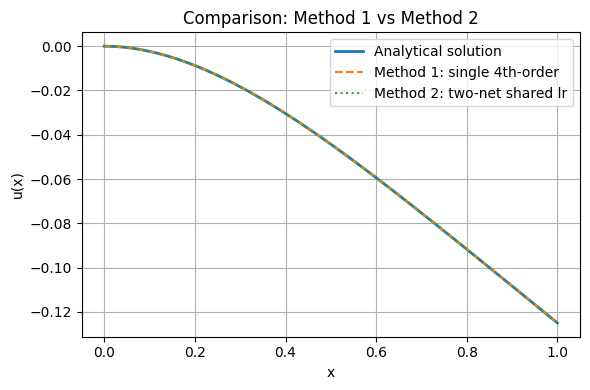

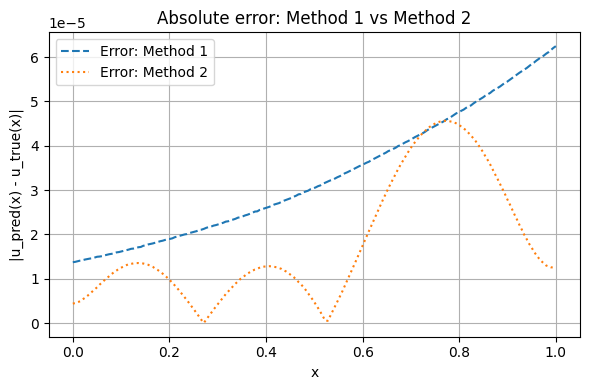

In [ ]:
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# Plot 1: Compare Method 1 (single 4th-order network)
#         vs Method 2 (two-network formulation)
# -------------------------------------------------------------
plt.figure(figsize=(6, 4))

# Analytical solution
plt.plot(x1, u_true1, label="Analytical solution", linewidth=2)

# Method 1: single network with 4th derivative
plt.plot(x1, u1, linestyle="--", label="Method 1: single 4th-order")

# Method 2: two-network formulation (u, v=u'')
plt.plot(x2, u2, linestyle=":", label="Method 2: two-net shared lr")

plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Comparison: Method 1 vs Method 2")
plt.legend()
plt.grid(True)
plt.tight_layout()


# Optional: absolute error comparison for 1 vs 2
plt.figure(figsize=(6, 4))

err1 = abs(u1 - u_true1)
err2 = abs(u2 - u_true2)

plt.plot(x1, err1, linestyle="--", label="Error: Method 1")
plt.plot(x2, err2, linestyle=":", label="Error: Method 2")

plt.xlabel("x")
plt.ylabel("|u_pred(x) - u_true(x)|")
plt.title("Absolute error: Method 1 vs Method 2")
plt.legend()
plt.grid(True)
plt.tight_layout()


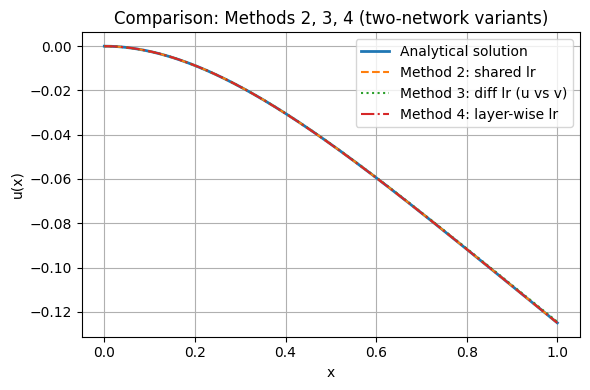

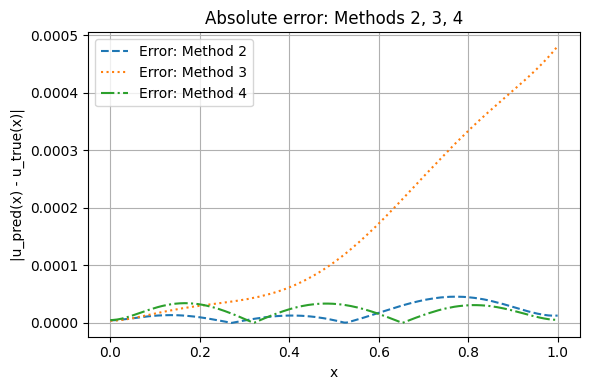

In [ ]:
# -------------------------------------------------------------
# Plot 2: Compare Methods 2, 3, 4 (all two-network variants)
# -------------------------------------------------------------
plt.figure(figsize=(6, 4))

# Use x2 (they should all be the same grid, but you can swap as needed)
plt.plot(x2, u_true2, label="Analytical solution", linewidth=2)

# Method 2: shared lr
plt.plot(x2, u2, linestyle="--", label="Method 2: shared lr")

# Method 3: different lr for u_net and v_net
plt.plot(x3, u3, linestyle=":", label="Method 3: diff lr (u vs v)")

# Method 4: layer-wise lr for u_net backbone/head
plt.plot(x4, u4, linestyle="-.", label="Method 4: layer-wise lr")

plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Comparison: Methods 2, 3, 4 (two-network variants)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Optional: absolute error comparison for 2, 3, 4
plt.figure(figsize=(6, 4))

err2 = abs(u2 - u_true2)
err3 = abs(u3 - u_true3)
err4 = abs(u4 - u_true4)

plt.plot(x2, err2, linestyle="--", label="Error: Method 2")
plt.plot(x3, err3, linestyle=":", label="Error: Method 3")
plt.plot(x4, err4, linestyle="-.", label="Error: Method 4")

plt.xlabel("x")
plt.ylabel("|u_pred(x) - u_true(x)|")
plt.title("Absolute error: Methods 2, 3, 4")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()



In [ ]:
### DeepXDE utilized

!pip install deepxde

import deepxde as dde
dde.backend.set_default_backend("pytorch")
from deepxde.backend import torch, backend_name

import numpy as np
import matplotlib.pyplot as plt

'''
"# DeepXDE will internally create tf.keras layers with these specs."
If there is any issue with torch.sin or other torch.###,
just replace it with tf.sin or tf.###.
'''

# # For reproducibility: fix all random seeds used by DeepXDE / TensorFlow backend
# dde.config.set_random_seed(1234)

In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np
import torch

# 2nd order derivative
def ddy(x, y):
    return dde.grad.hessian(y, x)

# grad.jacobina ~ 1st order derivative
# output: 1st order derivative of 2nd order derivative => 3rd order derivative
def dddy(x, y):
    return dde.grad.jacobian(ddy(x, y), x)

# residual = governing equation
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    dy_xxxx = dde.grad.hessian(dy_xx, x)
    return dy_xxxx + 1

# Applied only either left or right depending on conditions
'''
    Return True if the point lies on the boundary (x ≈ 1), otherwise False.
    - the boundary: left or right even top or bottom

    Parameters
    ----------
    x : array-like
        Coordinate of the evaluation point; x[0] is the spatial coordinate.
    on_boundary : bool
        True for boundary points, False for interior points.

    Logic
    -----
    - `on_boundary` ensures we only consider boundary points.
    - `dde.utils.isclose(x[0], 1)` selects those boundary points whose first
      coordinate is numerically close to 1 (x = 1).

    Use
    ---
    This function is used in a BC definition so that the boundary condition
    is enforced "only" on the right (or the left) boundary x = 1.
'''
def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)

def boundary_r(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)

# Exact solution
def func(x):
    return -(x**4) / 24 + x**3 / 6 - x**2 / 4

# =========================================================
# Geometry definition: (x) ∈ [0,1]
# =========================================================

# We define a 2D rectangular domain in the plane (x, λ),
# where:
#   x   ∈ [-1, 1]
# xmin and xmax are given as !D vectors [x_min, X_max].
geom = dde.geometry.Interval(0, 1)


# Four boundary conditions:
# bc1: Dirichlet at left boundary x=0 → u(0) = 0
bc1 = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_l)
# bc2: Neumann at left boundary x=0 → u_x(0) = 0
bc2 = dde.icbc.NeumannBC(geom, lambda x: 0, boundary_l)
# bc3: Operator BC at right boundary x=1 → u''(1) = 0  (uses ddy)
bc3 = dde.icbc.OperatorBC(geom, lambda x, y, _: ddy(x, y), boundary_r)
# bc4: Operator BC at right boundary x=1 → u'''(1) = 0 (uses dddy)
bc4 = dde.icbc.OperatorBC(geom, lambda x, y, _: dddy(x, y), boundary_r)

# PDE data object: 1D geometry + ODE + 4 BCs + optional exact solution
data = dde.data.PDE(
    geom,
    pde,                      # ODE residual function
    [bc1, bc2, bc3, bc4],     # list of boundary conditions
    num_domain=10,            # interior collocation points
    num_boundary=2,           # boundary collocation points
    solution=func,            # exact solution (for error metrics)
    num_test=100,             # test points
)

# Simple fully-connected network: 1D input → 3 hidden layers → 1D output
layer_size = [1] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

# Build and train PINN model with Adam optimizer
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

# Save and plot loss + prediction vs exact
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


# =========================================================
# Manual check of OperatorBC residual (bc3) using PyTorch
# =========================================================
# Convert DeepXDE test inputs to a torch tensor with gradients enabled
X_test = torch.tensor(
    data.test_x, dtype=torch.float32, requires_grad=True, device="cuda"
)

# Get the raw PyTorch network from DeepXDE model
net = model.net

# Forward pass to obtain NN outputs u(x) at test points
outputs = net(X_test)

# bc3.error expects NumPy arrays for x, and the same inputs/outputs as DeepXDE uses
residual_np = bc3.error(
    X_test.detach().cpu().numpy(),  # x as NumPy (no grad)
    X_test,                         # inputs (here torch tensor with grad)
    outputs,                        # network outputs u(x)
    0,                              # start index
    len(X_test),                    # end index
)

print("Raw residual values for OperatorBC (bc3):", residual_np)

# Convert residuals to torch tensor for MSE calculation
residual = torch.tensor(residual_np, dtype=torch.float32, device=X_test.device)
mse_residual = torch.mean(residual**2)

# MSE of the OperatorBC residual: should be small if BC is well satisfied
print("MSE of boundary residual for OperatorBC (u''(1) condition):")
print(mse_residual.item())
